# **Import Libraries**

In [ ]:
!pip install opendatasets
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import backend as k
import keras
from tensorflow.keras import datasets, layers, models, optimizers
import os
from pathlib import Path
import opendatasets as od

# **Import Data Set**

In [ ]:
# Download latest version
import kagglehub
site = kagglehub.dataset_download("alessiocorrado99/animals10")
path=Path('../versions/2/raw-img')

In [ ]:
import cv2
import os
from pathlib import Path
import shutil

def preprocess_images(input_dir, output_dir, target_size=(48, 48)):
  """Converts images in a directory to grayscale, resizes them, and saves them.

  Args:
    input_dir: Path to the directory containing the original images.
    output_dir: Path to the directory where the preprocessed images will be saved.
    target_size: Tuple (width, height) specifying the target image size.
  """
  shutil.rmtree(output_dir, ignore_errors=True) # Remove output directory if it exists
  shutil.copytree(input_dir, output_dir) # Copy directory structure
  for subdir, dirs, files in os.walk(output_dir): # Walk through copied directory
    for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(subdir, file)

        img = cv2.imread(input_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(gray_img, target_size)
        cv2.imwrite(input_path, resized_img) # Overwrite original with processed image


# Example usage:
input_directory = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"
output_directory = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/processed-img"
preprocess_images(input_directory, output_directory)


# **Loading the Dataset**



In [ ]:
directory = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/processed-img"
train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(48, 48),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=True,
    data_format=None,
    verbose=True
)

def preprocess_image(image, label):
      image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
      return image, label

print(train_ds.class_names)
train_ds

train_ds_np = tfds.as_numpy(train_ds)
test_ds_np = tfds.as_numpy(test_ds)

X_train, y_train, X_test, y_test = np.zeros([1,48,48,1]), np.zeros([1,10]), np.zeros([1,48,48,1]), np.zeros([1,10])

for ele in train_ds_np:
    X_train = np.append(X_train, ele[0].reshape([-1,48,48,1]), axis=0)
    y_train = np.append(y_train, ele[1].reshape([-1,10]), axis=0)

for ele in test_ds_np:
    X_test = np.append(X_test, ele[0].reshape([-1,48,48,1]), axis=0)
    y_test = np.append(y_test, ele[1].reshape([-1,10]), axis=0)

X_train, y_train, X_test, y_test = X_train[1:,:,:,:], y_train[1:,:], X_test[1:,:,:,:], y_test[1:,:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_train[421], y_test[100]

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Using 5235 files for validation.
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
(20944, 48, 48, 1) (20944, 10) (5235, 48, 48, 1) (5235, 10)


(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

# **Showing the Data**

In [ ]:
import random

def generate_unique_random_integers(start, end, count):
  if start >= end or count > (end - start + 1):
    return "Invalid Input"
  unique_integers = set()
  while len(unique_integers) < count:
    unique_integers.add(random.randint(start, end))
  return list(unique_integers)

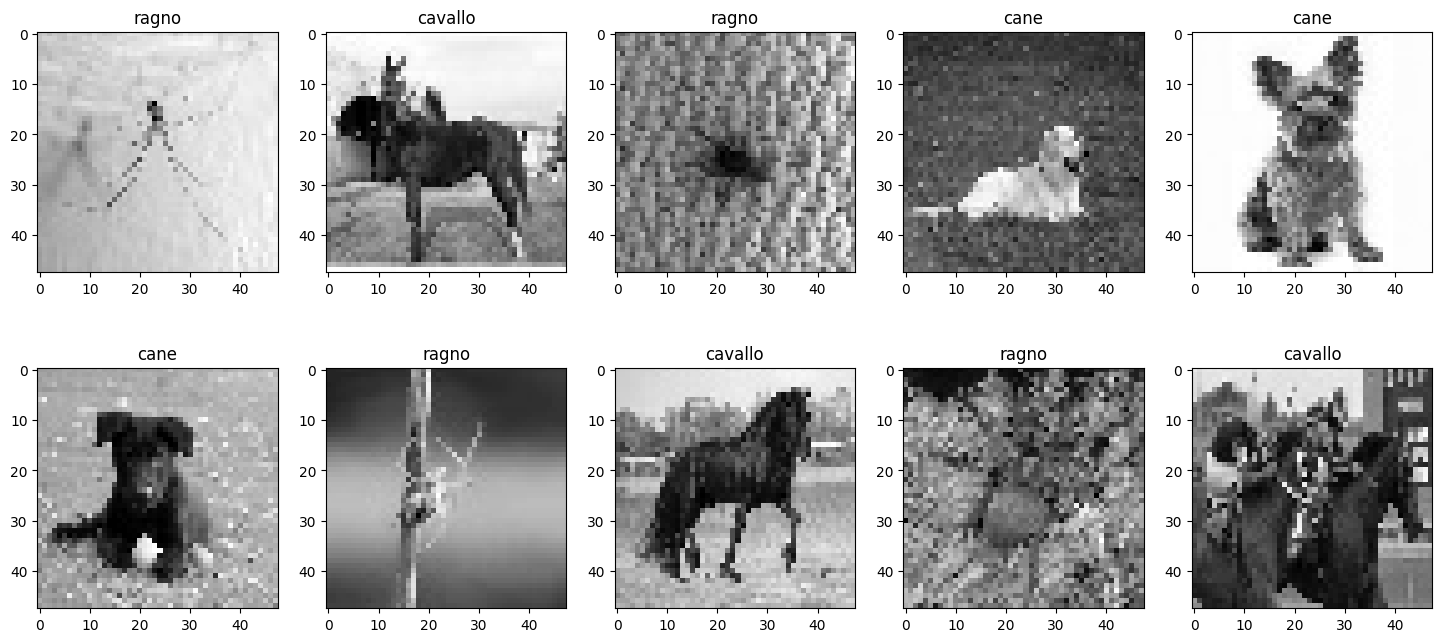

In [ ]:
random_image_index = generate_unique_random_integers(0, X_train.shape[0]-2, 10)
plt.figure(figsize=(18,8))
for i in range(len(random_image_index)):
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[random_image_index[i]], cmap='gray')
  plt.title(train_ds.class_names[np.argmax(y_train[random_image_index[i]])])
plt.show()

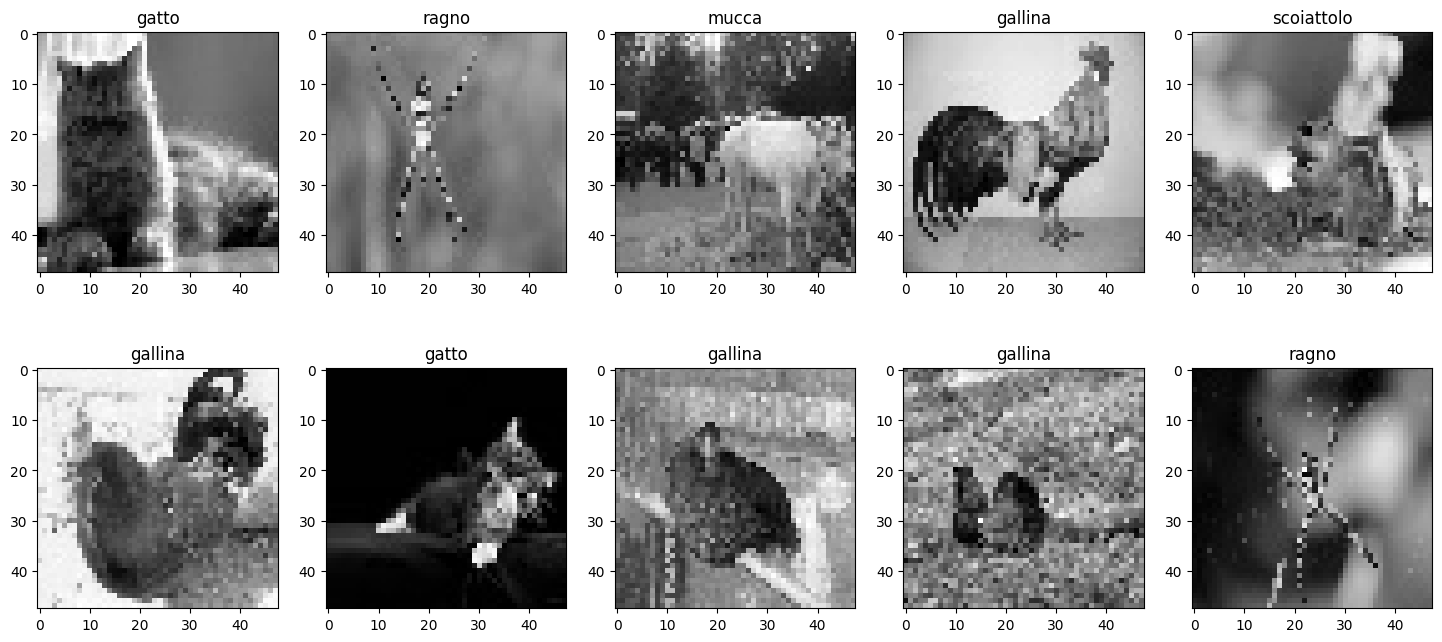

In [ ]:
random_image_index = generate_unique_random_integers(0, 5235, 10)
plt.figure(figsize=(18,8))
for i in range(len(random_image_index)):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[random_image_index[i]], cmap='gray')
  plt.title(train_ds.class_names[np.argmax(y_test[random_image_index[i]])])
plt.show()

# **CNN Model**

In [ ]:
X_train_normalized = X_train.astype('float32')
X_test_normalized = X_test.astype('float32')
X_train_normalized /= 255.0
X_test_normalized /= 255.0


model =  models.Sequential([
    layers.Conv2D(64, (5, 5), strides=2, activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_normalized, y_train, epochs=40, batch_size = 128,  validation_data=(X_test_normalized, y_test))
#

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 22, 22, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,512,202 (5.77 MB)

 Trainable params: 1,512,202 (5.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 92s 548ms/step - accuracy: 0.1795 - loss: 2.2227 - val_accuracy: 0.2682 - val_loss: 2.0693
Epoch 2/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 533ms/step - accuracy: 0.2720 - loss: 2.0468 - val_accuracy: 0.3463 - val_loss: 1.8312
Epoch 3/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 87s 531ms/step - accuracy: 0.3741 - loss: 1.7913 - val_accuracy: 0.4309 - val_loss: 1.6434
Epoch 4/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 142s 534ms/step - accuracy: 0.4477 - loss: 1.5925 - val_accuracy: 0.4879 - val_loss: 1.5065
Epoch 5/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 142s 532ms/step - accuracy: 0.4941 - loss: 1.4599 - val_accuracy: 0.4993 - val_loss: 1.4875
Epoch 6/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 144s 543ms/step - accuracy: 0.5335 - loss: 1.3592 - val_accuracy: 0.5559 - val_loss: 1.3418
Epoch 7/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 142s 541ms/step - accuracy: 0.5713 - loss: 1.2452 - val_accuracy: 0.5633 - val_loss: 1.3093
Epoch 8/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.6148 - lo

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test_normalized, y_test, verbose=2)
print("Test Accuracy: ", test_acc)

164/164 - 1s - 6ms/step - accuracy: 0.5744 - loss: 3.2663
Test Accuracy:  0.5744030475616455


In [ ]:
y_pred = model.predict(X_test_normalized)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


IndexError: index 7715 is out of bounds for axis 0 with size 5235

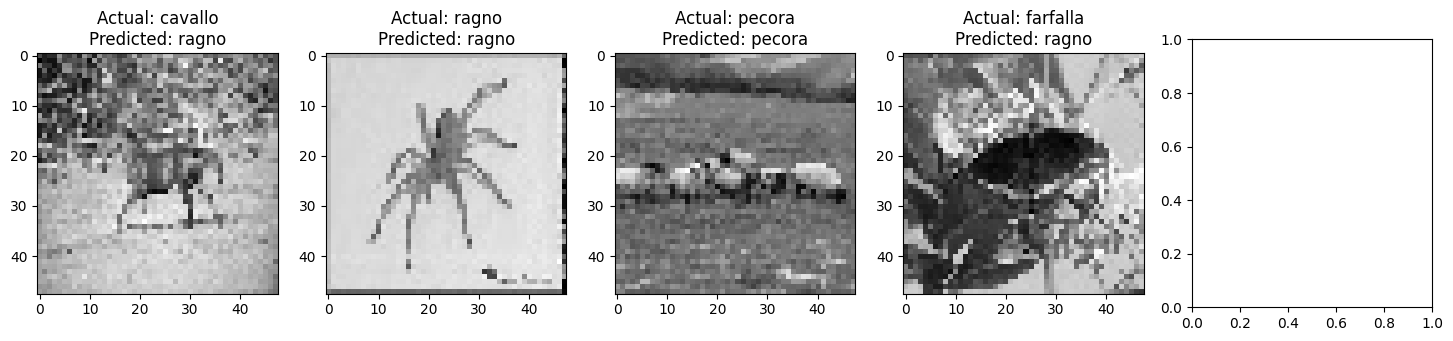

In [ ]:
random_image_index = generate_unique_random_integers(0, 10000, 20)
plt.figure(figsize=(18,16))
for i in range(len(random_image_index)):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[random_image_index[i]], cmap='gray')
    plt.title("Actual: "+test_ds.class_names[np.argmax(y_test[random_image_index[i]])]+"\nPredicted: "+test_ds.class_names[np.argmax(y_pred[random_image_index[i]])])
plt.show()